In [1]:
import scipy
import numpy as np
import matplotlib.pyplot as plt
import torch

from utils import matrl2_error, rl2_error
from ops import injection2d, injection4d 
from ops import interp2d, interp1d_cols, interp1d_rows
from ops import restrict2d
from ops import fetch_nbrs2d #, fetch_nbrs4d
from ops import coord2idx2d, coord2idx4d
from ops import cat2d_nbr_coords
from ops import grid2d_coords, grid4d_coords
from einops import rearrange

from mlmm import Grid2D, f_local_fetching_2D
from mlmm import K_local_interp_4D, K_local_eval_4D

In [2]:
l = 129
poisson_data = scipy.io.loadmat(f'../pde_data/green_learning/data2d_{l}/poisson.mat')
F = poisson_data['F']

In [3]:
def kernel_func(pts_pairs):
    x1 = pts_pairs[:,0]
    y1 = pts_pairs[:,1]

    x2 = pts_pairs[:,2]
    y2 = pts_pairs[:,3]

    mask = ((x1**2+y1**2) < 1) & ((x2**2+y2**2) < 1)

    k = 1/(4*torch.pi) * torch.log(((x1 - x2)**2 + (y1-y2)**2) / ((x1*y2-x2*y1)**2 + (x1*x2+y1*y2-1)**2))
    k = torch.nan_to_num(k, neginf=-2) * mask

    return k

In [4]:
def ffunc(pts):
    x = pts[:,0]
    y = pts[:,1]
    u = (1 - (x**2+y**2))**-0.5
    u = torch.nan_to_num(u, posinf=0)
    return u

In [7]:
# two level mm

l= 7
nh = 2**l+1 # total level
nH = 2**(l-1) + 1
k = 1 # coarse level
d = 1 # problem dimension
m = 1 # local range

fine_grid = Grid2D(nh, m)
coarse_grid = Grid2D(nH, m)

# full eval
f_h = torch.tensor(F[:,10]).float().reshape(nh,nh)
K_hh = kernel_func(fine_grid.x_hh.reshape(-1,4))
h = fine_grid.h 
nh = fine_grid.nh
hh = h**2
u_h = hh * (K_hh.reshape(nh*nh, nh*nh) @ f_h.reshape(-1)).reshape(nh,nh)

H = coarse_grid.h 
nH = coarse_grid.nh
HH = H**2
f_H = restrict2d(f_h[None,None])[0,0]
K_HH = kernel_func(coarse_grid.x_hh.reshape(-1,4))
u_H = HH * (K_HH.reshape(nH*nH, nH*nH) @ f_H.reshape(-1)).reshape(nH,nH)
u_h_ = interp2d(u_H[None,None])[0,0].reshape(-1) # without correction
print("m {:} : {:.4e} ".format(
    2*m, matrl2_error(u_h_, u_h).numpy()))

K_IJ = K_HH[coarse_grid.ij_idx]
K_IJ = K_IJ.reshape(nH,nH,2*m+1,2*m+1)

x_2I2J = coarse_grid.x_ij
x_2Ij = interp2d(x_2I2J.permute(0,3,1,2)).permute(0,2,3,1)
x_2Ij = rearrange(x_2Ij, '(m n) x y c-> m n x y c', m=nH, n=nH)
K_local, K_2Ij = K_local_eval_4D(x_2Ij, kernel_func)
K_local_ = K_local_interp_4D(K_IJ, K_2Ij)
f_local = [f_h.reshape(-1)[idx] for idx in coarse_grid.fetch_f_local_idx()]


u_H_ = u_H.reshape(-1) + hh*(
    (K_local[0] - K_local_[0]) * f_local[0]).sum(axis=-1)
u_H_ = u_H_ + hh*(
    (K_local[1] - K_local_[1]) * f_local[1]).sum(axis=-1)
u_H_ = u_H_.reshape(nH,nH)
u_h_ = interp2d(u_H_[None,None])[0,0]
print("m {:} : {:.4e} ".format(
    2*m, matrl2_error(u_h_, u_h).numpy()))
u_h_[1:-1:2,::2] = u_h_[1:-1:2,::2] + \
      hh*((K_local[2] - K_local_[2]) * f_local[2]).sum(
        axis=-1).reshape(nH-1, nH)
print("m {:} : {:.4e} ".format(
    2*m, matrl2_error(u_h_, u_h).numpy()))
u_h_[::2, 1:-1:2] = u_h_[::2, 1:-1:2] + \
      hh*((K_local[3] - K_local_[3]) * f_local[3]).sum(
        axis=-1).reshape(nH, nH-1)
print("m {:} : {:.4e} ".format(
    2*m, matrl2_error(u_h_, u_h).numpy()))
u_h_[1:-1:2, 1:-1:2] = u_h_[1:-1:2, 1:-1:2] + \
      hh*((K_local[4] - K_local_[4]) * f_local[4]).sum(
        axis=-1).reshape(nH-1, nH-1)
print("m {:} : {:.4e} ".format(
    2*m, matrl2_error(u_h_, u_h).numpy()))

m 2 : 1.7388e-02 
m 2 : 3.7460e-03 
m 2 : 3.5896e-03 
m 2 : 3.5104e-03 
m 2 : 3.3654e-03 


In [12]:
f_local = f_local_fetching_2D(f_h.reshape(-1), coarse_grid)
u_H = HH * (K_HH.reshape(nH*nH, nH*nH) @ f_H.reshape(-1)).reshape(nH,nH)
u_H_ = u_H.reshape(-1) + hh*(
    (K_local[0] - K_local_[0]) * f_local[0]).sum(axis=-1)
u_H_ = u_H_ + hh*(
    (K_local[1] - K_local_[1]) * f_local[1]).sum(axis=-1)
u_H_ = u_H_.reshape(nH,nH)
u_h_ = interp2d(u_H_[None,None])[0,0]
print("m {:} : {:.4e} ".format(
    2*m, matrl2_error(u_h_, u_h).numpy()))
u_h_[1:-1:2,::2] = u_h_[1:-1:2,::2] + \
      hh*((K_local[2] - K_local_[2]) * f_local[2]).sum(
        axis=-1).reshape(nH-1, nH)
print("m {:} : {:.4e} ".format(
    2*m, matrl2_error(u_h_, u_h).numpy()))
u_h_[::2, 1:-1:2] = u_h_[::2, 1:-1:2] + \
      hh*((K_local[3] - K_local_[3]) * f_local[3]).sum(
        axis=-1).reshape(nH, nH-1)
print("m {:} : {:.4e} ".format(
    2*m, matrl2_error(u_h_, u_h).numpy()))
u_h_[1:-1:2, 1:-1:2] = u_h_[1:-1:2, 1:-1:2] + \
      hh*((K_local[4] - K_local_[4]) * f_local[4]).sum(
        axis=-1).reshape(nH-1, nH-1)
print("m {:} : {:.4e} ".format(
    2*m, matrl2_error(u_h_, u_h).numpy()))

m 2 : 3.7460e-03 
m 2 : 3.5896e-03 
m 2 : 3.5104e-03 
m 2 : 3.3654e-03 


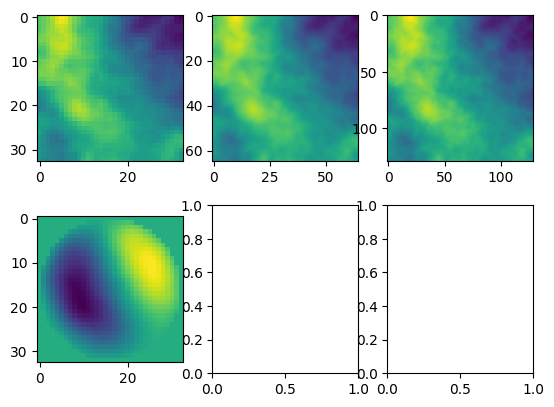

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=3)
axs[0][0].imshow(ml_f_h[0])
axs[0][1].imshow(ml_f_h[1])
axs[0][2].imshow(ml_f_h[2])
axs[1][0].imshow(u_H)